# Module

## **Essential functions**

### ***Visualizer***

#### Heatmap

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def show_heat_map(data, title='Heatmap'):
    """
    Vẽ heatmap cho cả DataFrame và Series
    - DataFrame: vẽ heatmap bình thường
    - Series: convert thành DataFrame (1 cột)
    """

    # Nếu là Series → convert sang DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame(name=data.name if data.name else 'value')

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        data,
        annot=True,
        cmap='coolwarm',
        fmt='.4f',
        vmin=0,
        vmax=1,
        center=0.5
    )
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

#### Column plot

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings


def show_column(data, column_name, bins=5):
    """
    Vẽ biểu đồ cột, gom nhóm (binning) cho dữ liệu số
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

    # Kiểm tra cột tồn tại
    if column_name not in data.columns:
        print(f"Cột '{column_name}' không tìm thấy.")
        return

    plt.figure(figsize=(12, 6))

    # Gom nhóm
    plot_data = data.copy()
    x_axis = column_name

    if pd.api.types.is_numeric_dtype(data[column_name]):
        x_axis = f"{column_name}_groups"
        # pd.cut sẽ chia dữ liệu thành 'bins' khoảng bằng nhau
        plot_data[x_axis] = pd.cut(data[column_name], bins=bins)
        print(f"-> Đã gom '{column_name}' thành {bins} nhóm.")

    if pd.api.types.is_numeric_dtype(data[column_name]) and bins is None:
        # Số (không gom nhóm): Sắp xếp theo giá trị
        order = sorted(plot_data[x_axis].unique())
    elif bins is not None:
        order = sorted(plot_data[x_axis].unique().astype(str))
        order = None
    else:
        # cột chữ
        order = plot_data[x_axis].value_counts().index

    # Vẽ biểu đồ
    sns.countplot(x=x_axis, data=plot_data, order=order, palette='Greens')
    
    # Tính skewness
    skew_text = ""
    if pd.api.types.is_numeric_dtype(data[column_name]):
        skew_val = data[column_name].skew()
        meaning = ""
        if skew_val > 1:
            meaning = "(Lệch phải)"
        elif skew_val < -1:
            meaning = "(Lệch trái)"
        elif -0.5 <= skew_val <= 0.5:
            meaning = "(Đối xứng)"
        skew_text = f"\nSkewness (Gốc): {skew_val:.2f} {meaning}"

    # Trang trí
    plt.title(f'Plot of {column_name} {("(Gom " + str(bins) + " nhóm)") if bins else ""}{skew_text}', fontsize=14)
    plt.xlabel(x_axis, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


#### Pie Chart

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings


def show_pie_chart(
    data,
    column_name,
    min_percent=2,
    min_other_percent=3
):
    """
    Vẽ pie chart CHỈ cho dữ liệu categorical
    - Gộp lát nhỏ vào 'Others'
    - Ẩn 'Others' nếu quá nhỏ
    - Dùng palette seaborn: Greens
    """

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Kiểm tra cột
        if column_name not in data.columns:
            print(f"Cột '{column_name}' không tồn tại.")
            return

        col_data = data[column_name].dropna()

        # ===== Count =====
        counts = col_data.value_counts()

        total = counts.sum()
        percents = counts / total * 100

        # ===== Gộp lát nhỏ =====
        small_mask = percents < min_percent
        if small_mask.any():
            others_sum = counts[small_mask].sum()
            others_percent = others_sum / total * 100
            counts = counts[~small_mask]

            if others_percent >= min_other_percent:
                counts['Others'] = others_sum

        # ===== Palette =====
        colors = sns.color_palette("Greens", n_colors=len(counts))

        # ===== Plot =====
        plt.figure(figsize=(8, 8))
        plt.pie(
            counts,
            labels=counts.index.astype(str),
            autopct='%1.1f%%',
            startangle=90,
            counterclock=False,
            colors=colors,
            textprops={'fontsize': 28}
        )
        plt.title(f'Pie Chart of {column_name}', fontsize=14)
        plt.tight_layout()
        plt.show()


### ***Metric Funcs***

#### StatisticsAnalyzer

In [4]:
import pandas as pd

class StatisticsAnalyzer:
    """
    Tính độ đo phân tán (metrics of spread)
    """

    def __init__(self, dataframe):
        self.numeric_df = dataframe.select_dtypes(include='number')
        print(f"Chọn {len(self.numeric_df.columns)} là cột dữ liệu số để phân tích.")

    def calculate_spread_metrics(self):
        """
        Các độ đo bao gồm: Range, Variance, Standard Deviation
        """
        print("Tính toán các độ đo phân tán")
        data_range = self.numeric_df.max() - self.numeric_df.min()
        variance = self.numeric_df.var()
        std_dev = self.numeric_df.std()

        # Tổng hợp kết quả
        spread_df = pd.DataFrame({
            'Range': data_range,
            'Variance': variance,
            'Std_Deviation': std_dev,
        })

        return spread_df

#### Correlation

In [5]:
import pandas as pd
import numpy as np  
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2, p, _, _ = chi2_contingency(confusion)
    n = confusion.sum().sum()
    r, k = confusion.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

def calc_correlation(
        df: pd.DataFrame,
        continuous_columns: list = None, 
        categorical_columns: list = None, 
        ordinal_columns: list = None,
        target : str = None,
    ) -> pd.DataFrame:    
    """
    Tính ma trận tương quan cho DataFrame với phương pháp bất kỳ:
    - 'pearson': cho dữ liệu liên tục
    - 'spearman': cho dữ liệu thứ bậc (ordinal)

    Args:
        df (pd.DataFrame): dữ liệu đầu vào
        continuous_columns (list): danh sách các cột liên tục (optional)
        categorical_columns (list): danh sách các cột phân loại (optional)
        save_path (str): đường dẫn để lưu file CSV (optional)

    Returns:
        pd.DataFrame: bảng correlation matrix
    """
    # Add target to all lists
    if continuous_columns and target in continuous_columns:
        continuous_columns.remove(target)
    if categorical_columns and target in categorical_columns:
        categorical_columns.remove(target)
    if ordinal_columns and target in ordinal_columns:
        ordinal_columns.remove(target)

    df_numeric = df[continuous_columns] if continuous_columns else pd.DataFrame()
    df_ordinal = df[ordinal_columns] if ordinal_columns else pd.DataFrame()
    df_categorical = df[categorical_columns] if categorical_columns else pd.DataFrame()

    # Correlation between features
    if df_numeric.shape[1] > 0:
        corr_numeric = df_numeric.corr(method="pearson")
    if df_ordinal.shape[1] > 0:
        corr_ordinal = df_ordinal.corr(method="spearman")
    else:
        print("No ordinal columns provided.")
        corr_ordinal = pd.DataFrame()

    if df_categorical.shape[1] > 0:
        corr_categorical = df_categorical.corr(method="kendall")
    else: 
        print("No categorical columns provided.")
        corr_categorical = pd.DataFrame()
    
    # Correlation between features and target
    if df_numeric.shape[1] > 0:
        corr_target_numeric = df_numeric.apply(
            lambda x: mutual_info_classif(
                x.values.reshape(-1, 1),
                df[target],
                random_state=42
            )[0]
        )
    else:
        print("No categorical columns provided.")
        corr_target_categorical = pd.Series()
    if df_categorical.shape[1] > 0:
        corr_target_categorical = df_categorical.apply(
            lambda x: cramers_v(x, df[target])
        )
    else:
        print("No categorical columns provided.")
        corr_target_categorical = pd.Series()

    return corr_numeric, corr_ordinal, corr_categorical, corr_target_numeric, corr_target_categorical


### ***Machine Learning Pipeline***

##### Models organize

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



import pandas as pd

In [7]:
model_dict = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ),

    "Decision Tree": DecisionTreeClassifier(
        max_depth=4,
        random_state=42,
        class_weight="balanced"
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        class_weight="balanced"
    ),

    "XGBoost": XGBClassifier(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    )
}

In [8]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

# **Dataset EDA**

## General Analysis - EDA Bước 1


In [9]:
import numpy as np 
import pandas as pd

df = pd.read_csv('../dataset/health_lifestyle_dataset.csv')

### First look at the dataset


In [10]:
df.head()

,id,age,gender,bmi,daily_steps,sleep_hours,water_intake_l,calories_consumed,smoker,alcohol,resting_hr,systolic_bp,diastolic_bp,cholesterol,family_history,disease_risk
0,1,56,Male,20.5,4198,3.9,3.4,1602,0,0,97,161,111,240,0,0
1,2,69,Female,33.3,14359,9.0,4.7,2346,0,1,68,116,65,207,0,0
2,3,46,Male,31.6,1817,6.6,4.2,1643,0,1,90,123,99,296,0,0
3,4,32,Female,38.2,15772,3.6,2.0,2460,0,0,71,165,95,175,0,0
4,5,60,Female,33.6,6037,3.8,4.0,3756,0,1,98,139,61,294,0,0


### Check column name


In [11]:
df.columns

Index(['id', 'age', 'gender', 'bmi', 'daily_steps', 'sleep_hours',
       'water_intake_l', 'calories_consumed', 'smoker', 'alcohol',
       'resting_hr', 'systolic_bp', 'diastolic_bp', 'cholesterol',
       'family_history', 'disease_risk'],
      dtype='object')

### Datatypes and null overview

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 100000 non-null  int64  
 1   age                100000 non-null  int64  
 2   gender             100000 non-null  object 
 3   bmi                100000 non-null  float64
 4   daily_steps        100000 non-null  int64  
 5   sleep_hours        100000 non-null  float64
 6   water_intake_l     100000 non-null  float64
 7   calories_consumed  100000 non-null  int64  
 8   smoker             100000 non-null  int64  
 9   alcohol            100000 non-null  int64  
 10  resting_hr         100000 non-null  int64  
 11  systolic_bp        100000 non-null  int64  
 12  diastolic_bp       100000 non-null  int64  
 13  cholesterol        100000 non-null  int64  
 14  family_history     100000 non-null  int64  
 15  disease_risk       100000 non-null  int64  
dtypes: 

### Datatype checking

In [13]:
import numpy as np 
import pandas as pd

class DataTypeChecker:
    def __init__(self, data: pd.DataFrame) -> dict:
        self.data = data    
    def check_column_types(self, show = True):
        """
        Check and print the data types of each column in the DataFrame.
        """
        df_dtype_mapping = {}
        for column, dtype in self.data.dtypes.items():
            df_dtype_mapping[column] = dtype

        # Show = True, display the data types
        if show:
            for column, dtype in df_dtype_mapping.items():
                print(f" - {column}: {self.data[column].head().values} ({dtype})")
        return df_dtype_mapping
check = DataTypeChecker(df)
data_type_check = check.check_column_types(show=True)

 - id: [1 2 3 4 5] (int64)
 - age: [56 69 46 32 60] (int64)
 - gender: ['Male' 'Female' 'Male' 'Female' 'Female'] (object)
 - bmi: [20.5 33.3 31.6 38.2 33.6] (float64)
 - daily_steps: [ 4198 14359  1817 15772  6037] (int64)
 - sleep_hours: [3.9 9.  6.6 3.6 3.8] (float64)
 - water_intake_l: [3.4 4.7 4.2 2.  4. ] (float64)
 - calories_consumed: [1602 2346 1643 2460 3756] (int64)
 - smoker: [0 0 0 0 0] (int64)
 - alcohol: [0 1 1 0 1] (int64)
 - resting_hr: [97 68 90 71 98] (int64)
 - systolic_bp: [161 116 123 165 139] (int64)
 - diastolic_bp: [111  65  99  95  61] (int64)
 - cholesterol: [240 207 296 175 294] (int64)
 - family_history: [0 0 0 0 0] (int64)
 - disease_risk: [0 0 0 0 0] (int64)


### Missing value checking

In [14]:
import pandas as pd

class missing_value_checking:
    def __init__(self, dataframe):
        self.df = dataframe
        self.results = {}

    def check_missing_values(self):
        """
        Kiểm tra các giá trị bị thiếu (missing values).
        """
        print("Start: Kiểm tra giá trị bị thiếu")
        total_rows = len(self.df)
        missing_count = self.df.isnull().sum()
        missing_percentage = (missing_count / total_rows)*100

        missing_df = pd.DataFrame({
            'count': missing_count,
            'percentage': missing_percentage
        })

        missing_df = missing_df[missing_df['count'] > 0]

        if missing_df.empty:
            print("--- Không có giá trị nào bị thiếu. ---")
            self.results['missing_values'] = "Không có giá trị nào bị thiếu"
        else:
            print(f"--- Tìm thấy {int(missing_df['count'].sum())} giá trị bị thiếu.---")
            self.results['missing_values'] = missing_df

checker = missing_value_checking(df)
missing_info = checker.check_missing_values()


Start: Kiểm tra giá trị bị thiếu
--- Không có giá trị nào bị thiếu. ---


### Dataset Distribution 

In [15]:
df.describe()

,id,age,bmi,daily_steps,sleep_hours,water_intake_l,calories_consumed,smoker,alcohol,resting_hr,systolic_bp,diastolic_bp,cholesterol,family_history,disease_risk
count,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,48.525990,29.024790,10479.87029,6.491784,2.751496,2603.341200,0.200940,0.300020,74.457420,134.58063,89.508850,224.300630,0.299150,0.248210
std,28867.657797,17.886768,6.352666,5483.63236,2.021922,1.297338,807.288563,0.400705,0.458269,14.423715,25.95153,17.347041,43.327749,0.457888,0.431976
min,1.000000,18.000000,18.000000,1000.00000,3.000000,0.500000,1200.000000,0.000000,0.000000,50.000000,90.00000,60.000000,150.000000,0.000000,0.000000
25%,25000.750000,33.000000,23.500000,5729.00000,4.700000,1.600000,1906.000000,0.000000,0.000000,62.000000,112.00000,74.000000,187.000000,0.000000,0.000000
50%,50000.500000,48.000000,29.000000,10468.00000,6.500000,2.800000,2603.000000,0.000000,0.000000,74.000000,135.00000,89.000000,224.000000,0.000000,0.000000
75%,75000.250000,64.000000,34.500000,15229.00000,8.200000,3.900000,3299.000000,0.000000,1.000000,87.000000,157.00000,105.000000,262.000000,1.000000,0.000000
max,100000.000000,79.000000,40.000000,19999.00000,10.000000,5.000000,3999.000000,1.000000,1.000000,99.000000,179.00000,119.000000,299.000000,1.000000,1.000000


## Xử lí dữ liệu (Bước 2)

### Check Null

In [16]:
df.isnull().sum().T

id                   0
age                  0
gender               0
bmi                  0
daily_steps          0
sleep_hours          0
water_intake_l       0
calories_consumed    0
smoker               0
alcohol              0
resting_hr           0
systolic_bp          0
diastolic_bp         0
cholesterol          0
family_history       0
disease_risk         0
dtype: int64

### Check unique

In [17]:
df["id"].is_unique

True

### Analyze Spread Metrics

In [18]:
Analyzer = StatisticsAnalyzer(df)
spread_metrics = Analyzer.calculate_spread_metrics()
print(spread_metrics)

Chọn 15 là cột dữ liệu số để phân tích.
Tính toán các độ đo phân tán
                     Range      Variance  Std_Deviation
id                 99999.0  8.333417e+08   28867.657797
age                   61.0  3.199365e+02      17.886768
bmi                   22.0  4.035636e+01       6.352666
daily_steps        18999.0  3.007022e+07    5483.632360
sleep_hours            7.0  4.088169e+00       2.021922
water_intake_l         4.5  1.683085e+00       1.297338
calories_consumed   2799.0  6.517148e+05     807.288563
smoker                 1.0  1.605647e-01       0.400705
alcohol                1.0  2.100101e-01       0.458269
resting_hr            49.0  2.080436e+02      14.423715
systolic_bp           89.0  6.734819e+02      25.951530
diastolic_bp          59.0  3.009198e+02      17.347041
cholesterol          149.0  1.877294e+03      43.327749
family_history         1.0  2.096614e-01       0.457888
disease_risk           1.0  1.866037e-01       0.431976


### Check outliers

In [19]:
import numpy as np 
import pandas as pd

class OutlierChecker():
    def __init__(self, data: pd.DataFrame) :
        self.columns_needing_check = ['age', 
            'bmi', 
            'daily_steps', 'sleep_hours', 
            'water_intake_l', 'calories_consumed',
            'resting_hr', 'systolic_bp', 'diastolic_bp'
            ]
        self.data = data
    def check_outlier(self, show = True) -> dict:
        outliers = {}
        for column in self.columns_needing_check:
            Q1 = self.data[column].quantile(0.25)
            Q3 = self.data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers[column] = self.data[(self.data[column] < lower_bound) | (self.data[column] > upper_bound)]
            if show:
                print(f"\nColumn: {column}")
                print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
                print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
                print(f"Number of outliers: {len(outliers[column])}")
        return outliers
    
check = OutlierChecker(df)
outliers = check.check_outlier()


Column: age
Q1: 33.00, Q3: 64.00, IQR: 31.00
Lower bound: -13.50, Upper bound: 110.50
Number of outliers: 0

Column: bmi
Q1: 23.50, Q3: 34.50, IQR: 11.00
Lower bound: 7.00, Upper bound: 51.00
Number of outliers: 0

Column: daily_steps
Q1: 5729.00, Q3: 15229.00, IQR: 9500.00
Lower bound: -8521.00, Upper bound: 29479.00
Number of outliers: 0

Column: sleep_hours
Q1: 4.70, Q3: 8.20, IQR: 3.50
Lower bound: -0.55, Upper bound: 13.45
Number of outliers: 0

Column: water_intake_l
Q1: 1.60, Q3: 3.90, IQR: 2.30
Lower bound: -1.85, Upper bound: 7.35
Number of outliers: 0

Column: calories_consumed
Q1: 1906.00, Q3: 3299.00, IQR: 1393.00
Lower bound: -183.50, Upper bound: 5388.50
Number of outliers: 0

Column: resting_hr
Q1: 62.00, Q3: 87.00, IQR: 25.00
Lower bound: 24.50, Upper bound: 124.50
Number of outliers: 0

Column: systolic_bp
Q1: 112.00, Q3: 157.00, IQR: 45.00
Lower bound: 44.50, Upper bound: 224.50
Number of outliers: 0

Column: diastolic_bp
Q1: 74.00, Q3: 105.00, IQR: 31.00
Lower bound

### Continuos, Categorical Recognition 

In [20]:
continuous_columns = [
    'age','bmi','daily_steps',
    'sleep_hours','water_intake_l',
    'calories_consumed','resting_hr',
    'systolic_bp','diastolic_bp', 
    'cholesterol'
]

categorical_columns = [
    'gender', 'smoker',
    'alcohol', 'family_history',
    'disease_risk'
]

## EDA Bước 2

### Uni-features

In [21]:
df.columns 

Index(['id', 'age', 'gender', 'bmi', 'daily_steps', 'sleep_hours',
       'water_intake_l', 'calories_consumed', 'smoker', 'alcohol',
       'resting_hr', 'systolic_bp', 'diastolic_bp', 'cholesterol',
       'family_history', 'disease_risk'],
      dtype='object')

#### Columns

**Xác định phân phối dữ liệu + hướng điền missing value hợp lí**

-> Đã gom 'age' thành 10 nhóm.


C:\Users\NewDat\AppData\Local\Temp\ipykernel_11004\1866076558.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=x_axis, data=plot_data, order=order, palette='Greens')


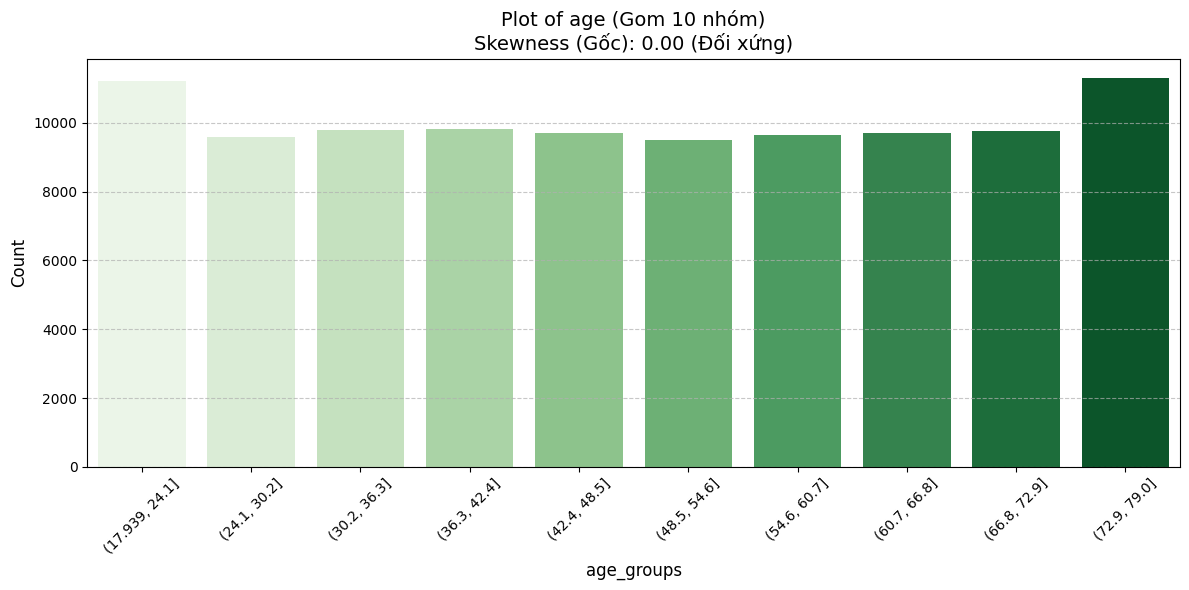

-> Đã gom 'bmi' thành 10 nhóm.


C:\Users\NewDat\AppData\Local\Temp\ipykernel_11004\1866076558.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=x_axis, data=plot_data, order=order, palette='Greens')


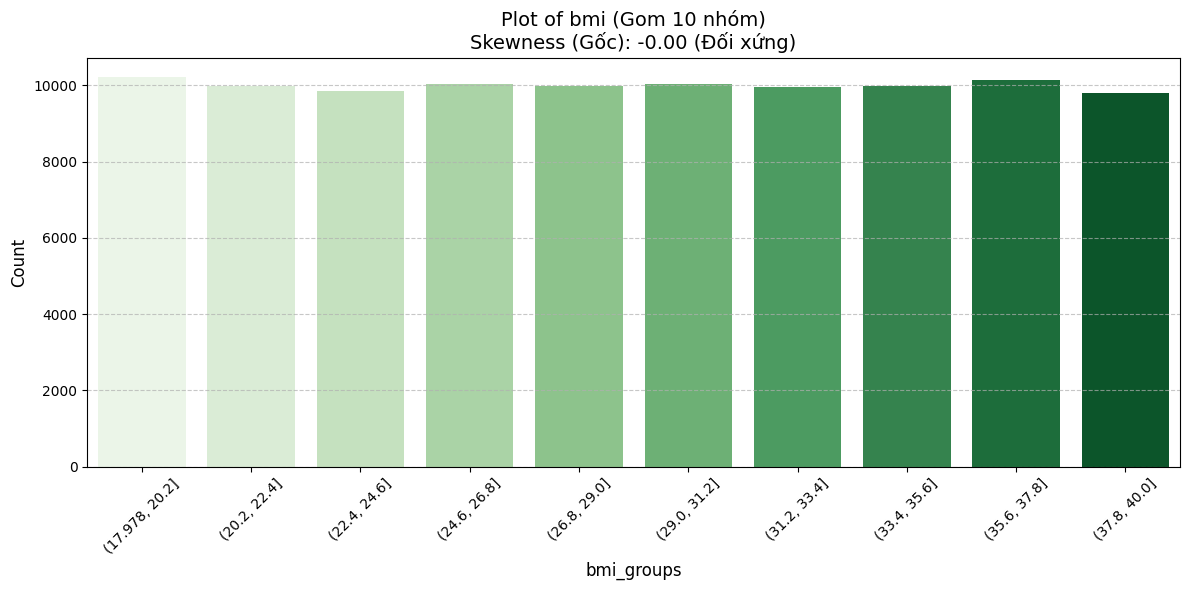

-> Đã gom 'daily_steps' thành 10 nhóm.


C:\Users\NewDat\AppData\Local\Temp\ipykernel_11004\1866076558.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=x_axis, data=plot_data, order=order, palette='Greens')


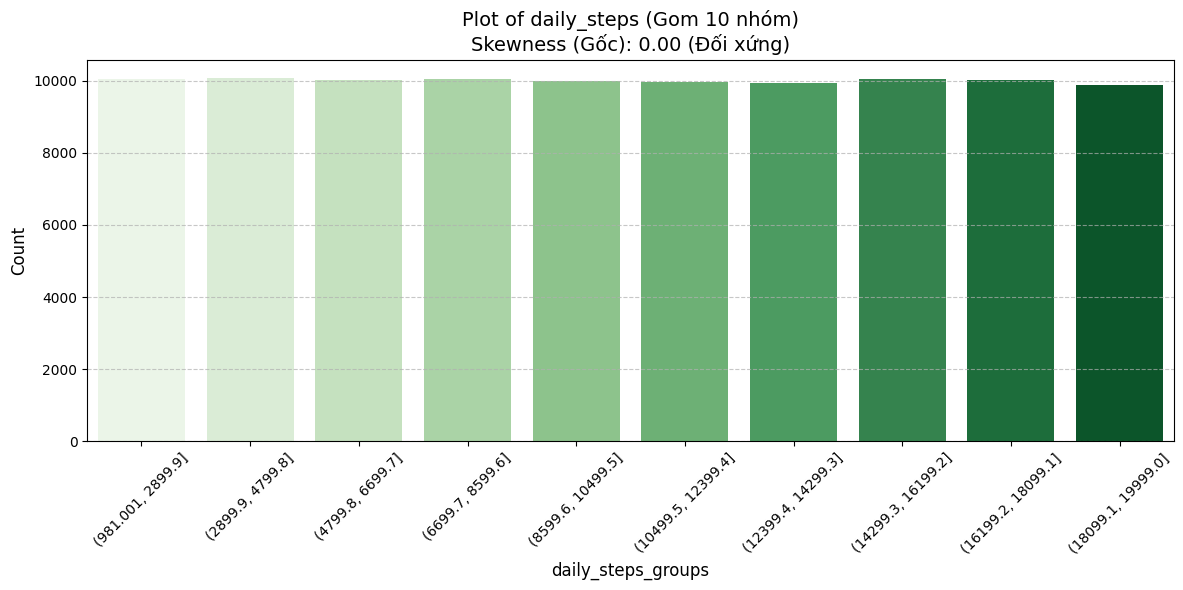

-> Đã gom 'sleep_hours' thành 10 nhóm.


C:\Users\NewDat\AppData\Local\Temp\ipykernel_11004\1866076558.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=x_axis, data=plot_data, order=order, palette='Greens')


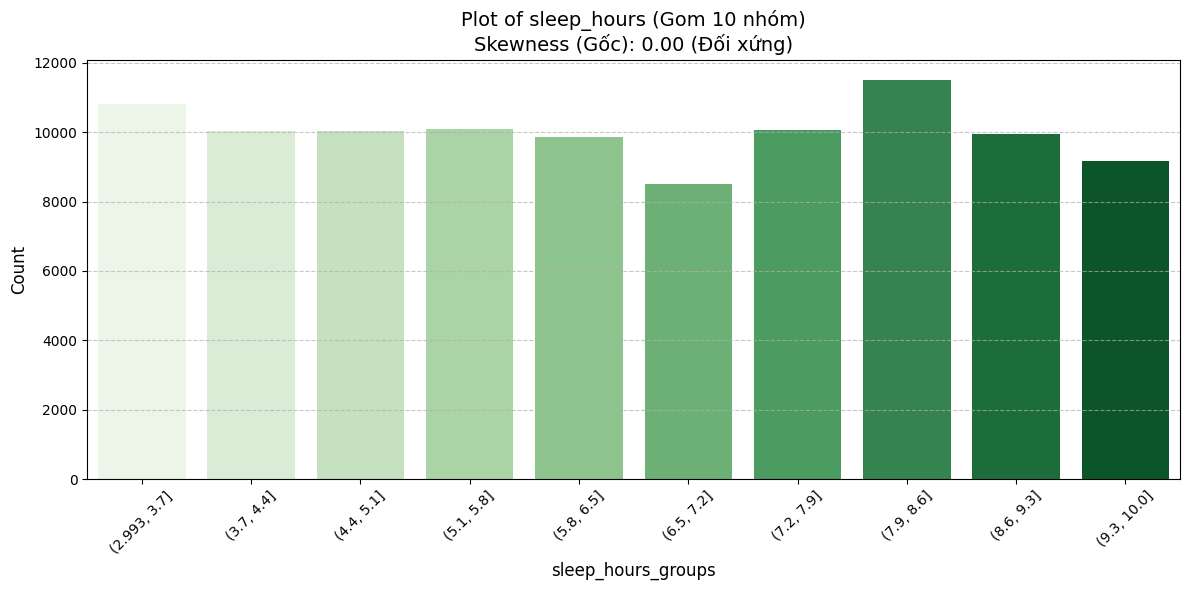

-> Đã gom 'water_intake_l' thành 10 nhóm.


C:\Users\NewDat\AppData\Local\Temp\ipykernel_11004\1866076558.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=x_axis, data=plot_data, order=order, palette='Greens')


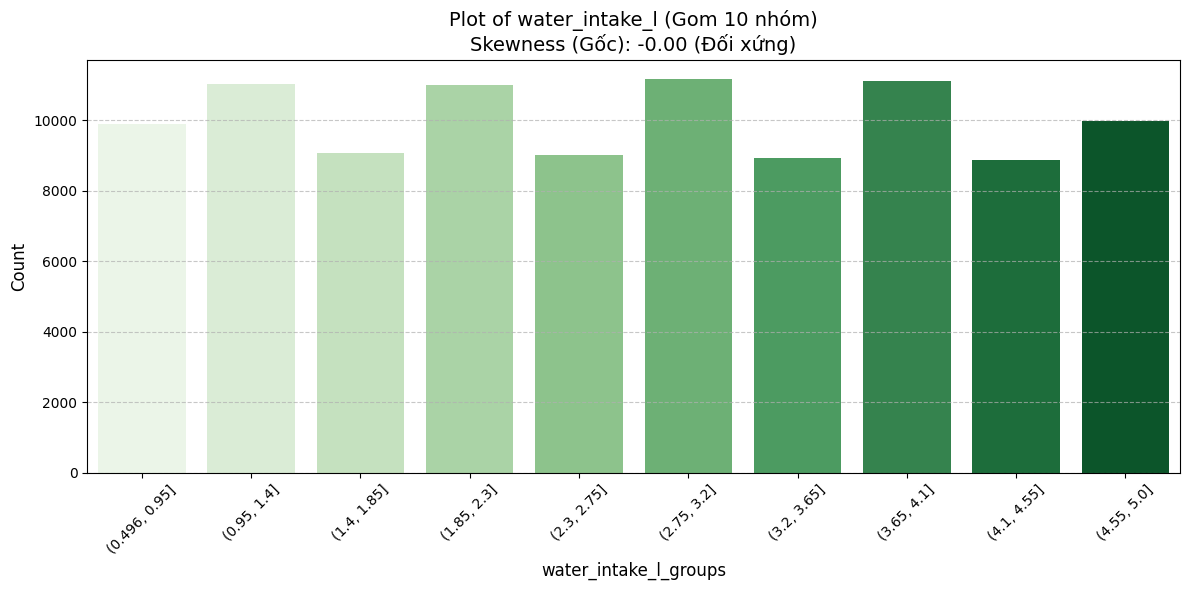

-> Đã gom 'calories_consumed' thành 10 nhóm.


C:\Users\NewDat\AppData\Local\Temp\ipykernel_11004\1866076558.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=x_axis, data=plot_data, order=order, palette='Greens')


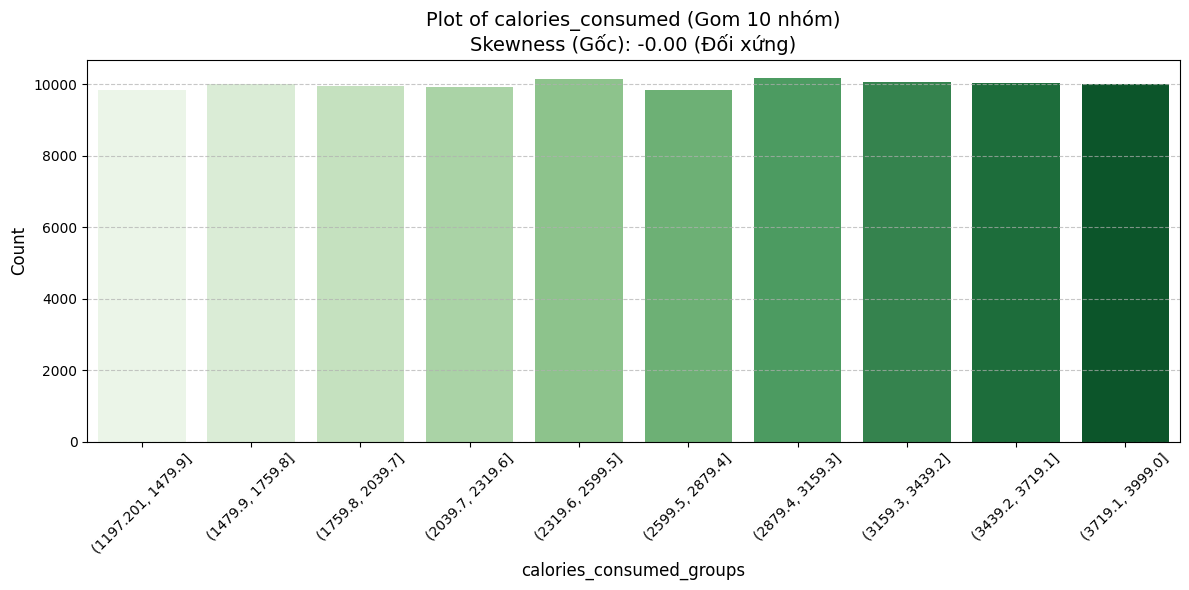

-> Đã gom 'resting_hr' thành 10 nhóm.


C:\Users\NewDat\AppData\Local\Temp\ipykernel_11004\1866076558.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=x_axis, data=plot_data, order=order, palette='Greens')


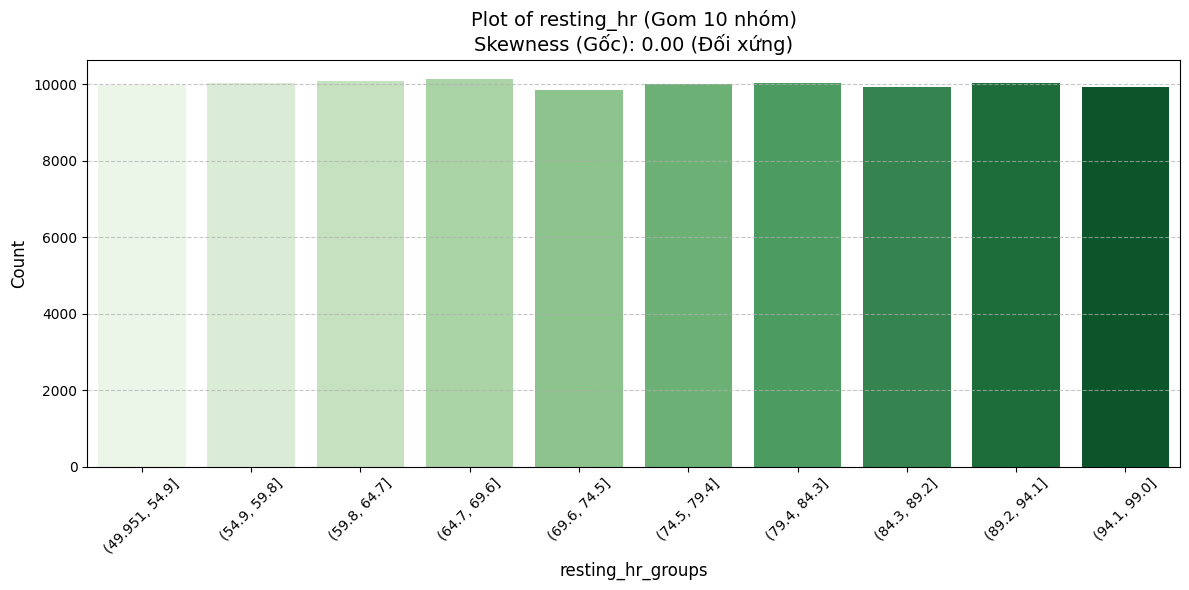

-> Đã gom 'systolic_bp' thành 10 nhóm.


C:\Users\NewDat\AppData\Local\Temp\ipykernel_11004\1866076558.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=x_axis, data=plot_data, order=order, palette='Greens')


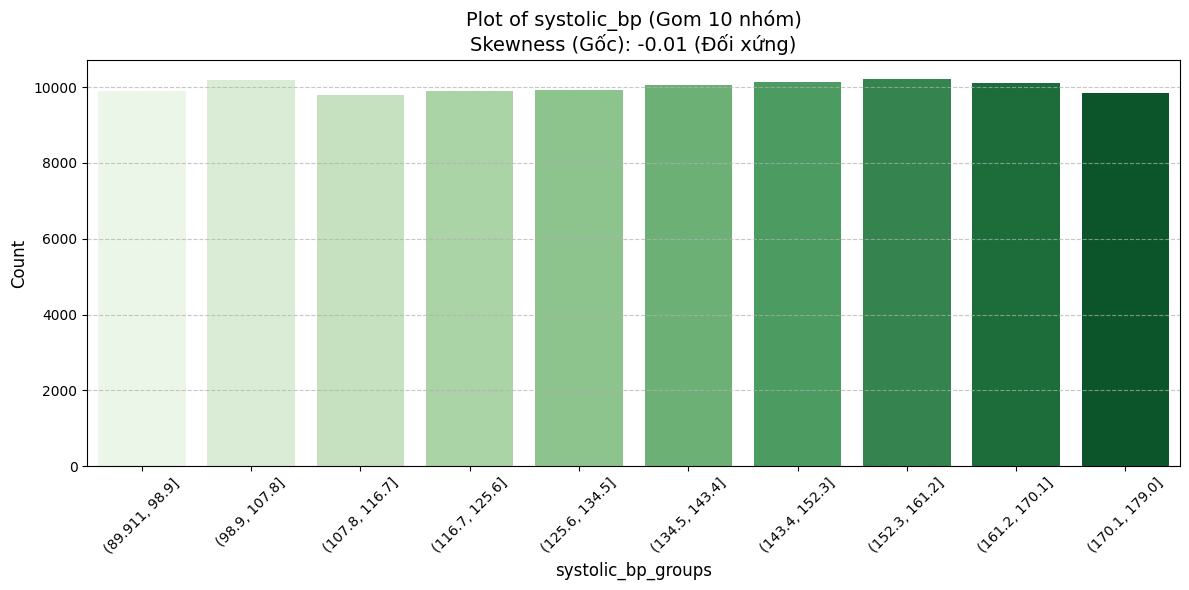

-> Đã gom 'diastolic_bp' thành 10 nhóm.


C:\Users\NewDat\AppData\Local\Temp\ipykernel_11004\1866076558.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=x_axis, data=plot_data, order=order, palette='Greens')


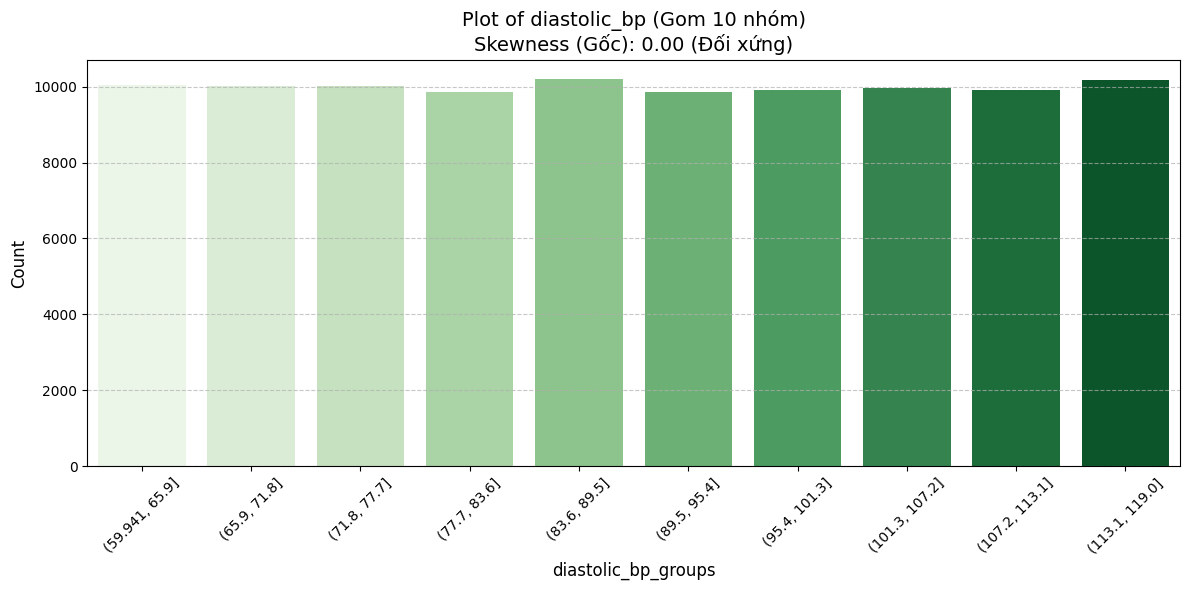

C:\Users\NewDat\AppData\Local\Temp\ipykernel_11004\1866076558.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=x_axis, data=plot_data, order=order, palette='Greens')


-> Đã gom 'cholesterol' thành 10 nhóm.


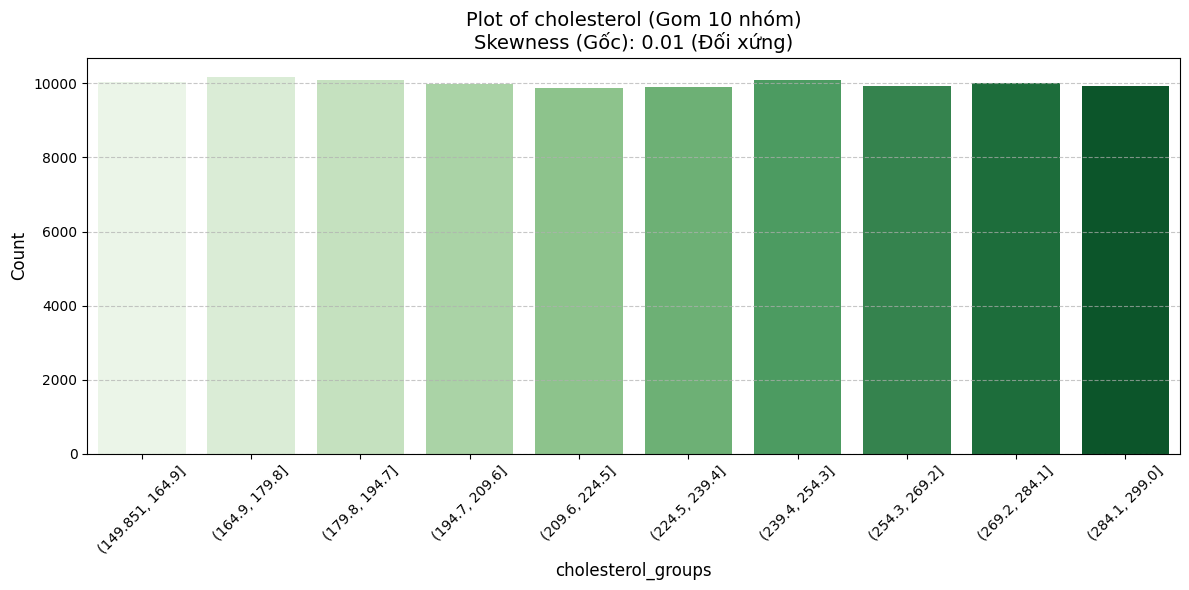

In [22]:
for col in continuous_columns:
    show_column(df, col, bins=10)

#### Pie chart

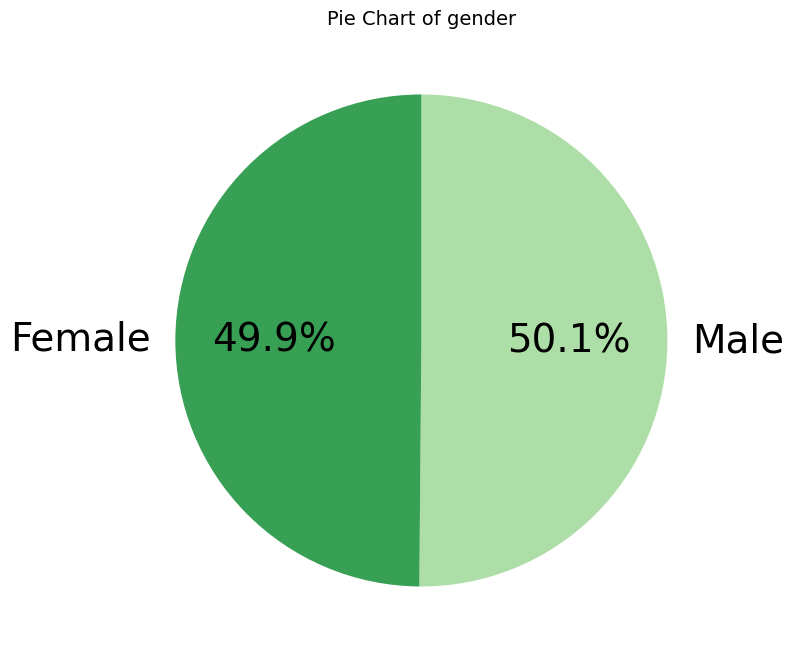

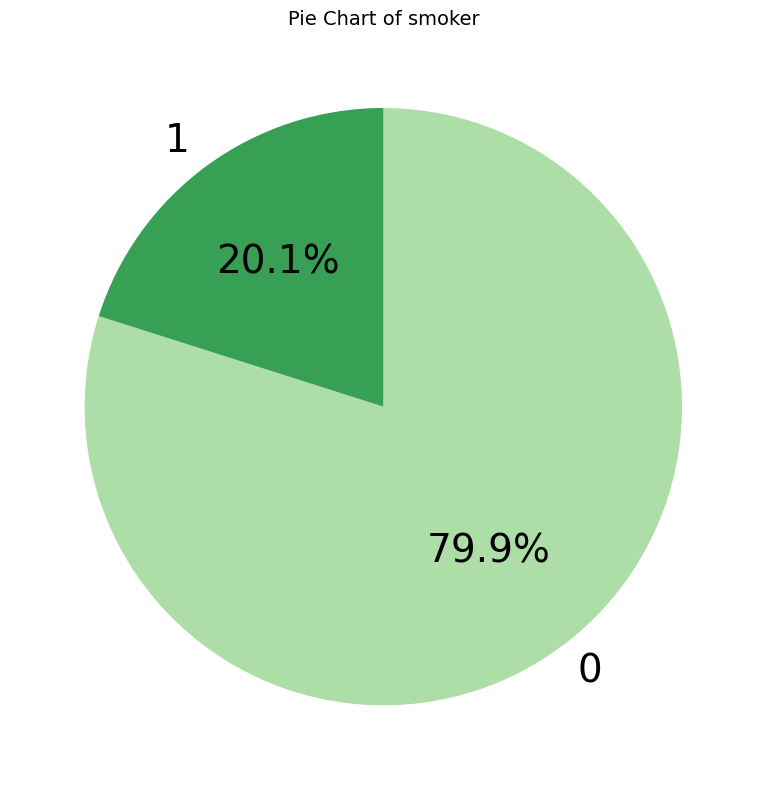

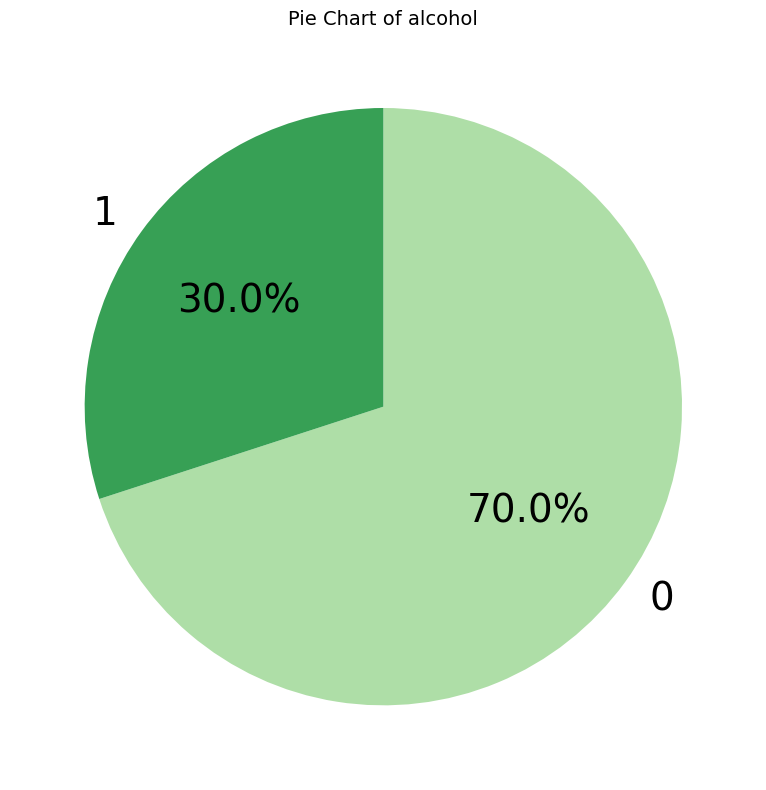

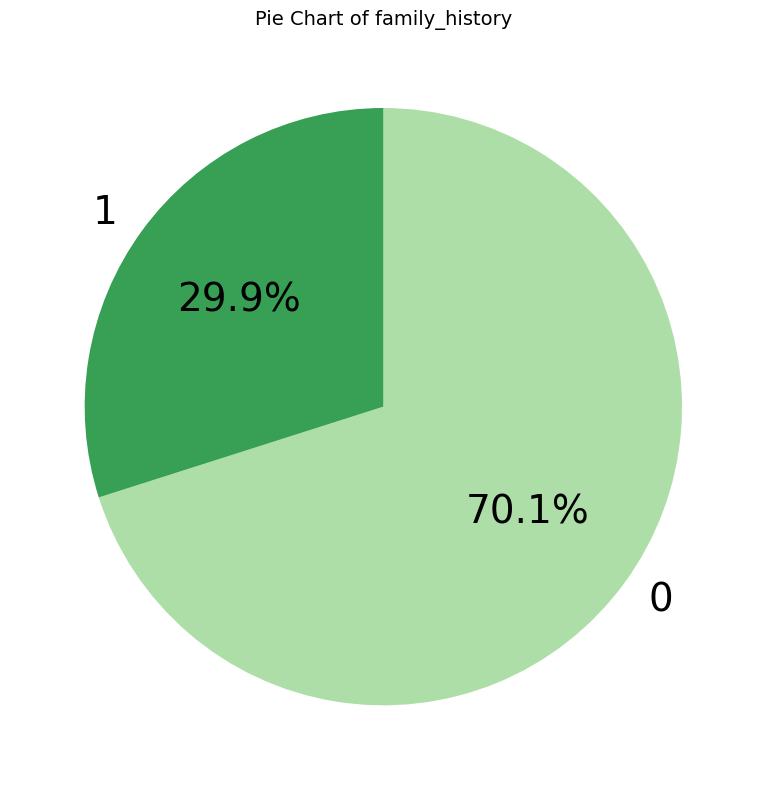

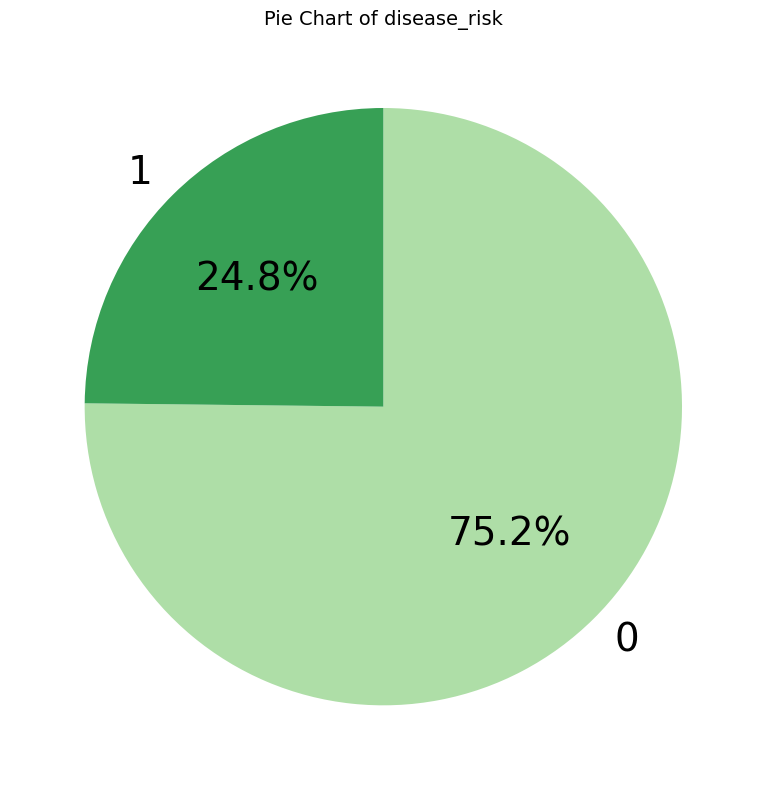

In [23]:
for col in categorical_columns:
    show_pie_chart(df, col)

### Bi-features 

#### Data_preparation

In [24]:
df_mean_1 = (
    df
    .assign(step_bin=pd.cut(df['daily_steps'], bins=10))
    .groupby('bmi', observed=True)
    .agg(
        daily_steps_mean=('daily_steps', 'mean'),
        calories_mean=('calories_consumed', 'mean')
    )
    .reset_index(drop=True)
)

In [25]:
df_mean_2 = (
    df
    .assign(step_bin=pd.cut(df['daily_steps'], bins=25))
    .groupby('step_bin', observed=True)
    .agg(
        daily_steps_mean=('daily_steps', 'mean'),
        bmi_mean=('bmi', 'mean')
    )
    .reset_index(drop=True)
)

In [26]:
df_bar_2 = (
    df
    .assign(step_bin=pd.cut(df['daily_steps'], bins=10))
    .groupby('step_bin', observed=True)
    .agg(bmi_mean=('bmi', 'mean'))
    .reset_index()
)

In [27]:
df_bar_1 = (
    df
    .assign(step_bin=pd.cut(df['daily_steps'], bins=10))
    .groupby('step_bin', observed=True)
    .agg(calories_mean=('calories_consumed', 'mean'))
    .reset_index()
)

In [28]:
df.columns

Index(['id', 'age', 'gender', 'bmi', 'daily_steps', 'sleep_hours',
       'water_intake_l', 'calories_consumed', 'smoker', 'alcohol',
       'resting_hr', 'systolic_bp', 'diastolic_bp', 'cholesterol',
       'family_history', 'disease_risk'],
      dtype='object')

In [29]:
ratio_df = (
    df
    .groupby('disease_risk')['smoker']
    .value_counts(normalize=True)
    .rename('ratio')
    .reset_index()
)

In [30]:
ratio_df_rest = (
    df
    .groupby('disease_risk')['resting_hr']
    .value_counts(normalize=True)
    .rename('ratio')
    .reset_index()
)

#### Plot drawing

In [31]:
df['disease_risk'].unique()

array([0, 1])

In [32]:
df.columns

Index(['id', 'age', 'gender', 'bmi', 'daily_steps', 'sleep_hours',
       'water_intake_l', 'calories_consumed', 'smoker', 'alcohol',
       'resting_hr', 'systolic_bp', 'diastolic_bp', 'cholesterol',
       'family_history', 'disease_risk'],
      dtype='object')

In [33]:
df['disease_risk'].unique()

array([0, 1])

C:\Users\NewDat\AppData\Local\Temp\ipykernel_11004\3424619896.py:40: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
C:\Users\NewDat\AppData\Local\Temp\ipykernel_11004\3424619896.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\NewDat\AppData\Local\Temp\ipykernel_11004\3424619896.py:87: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


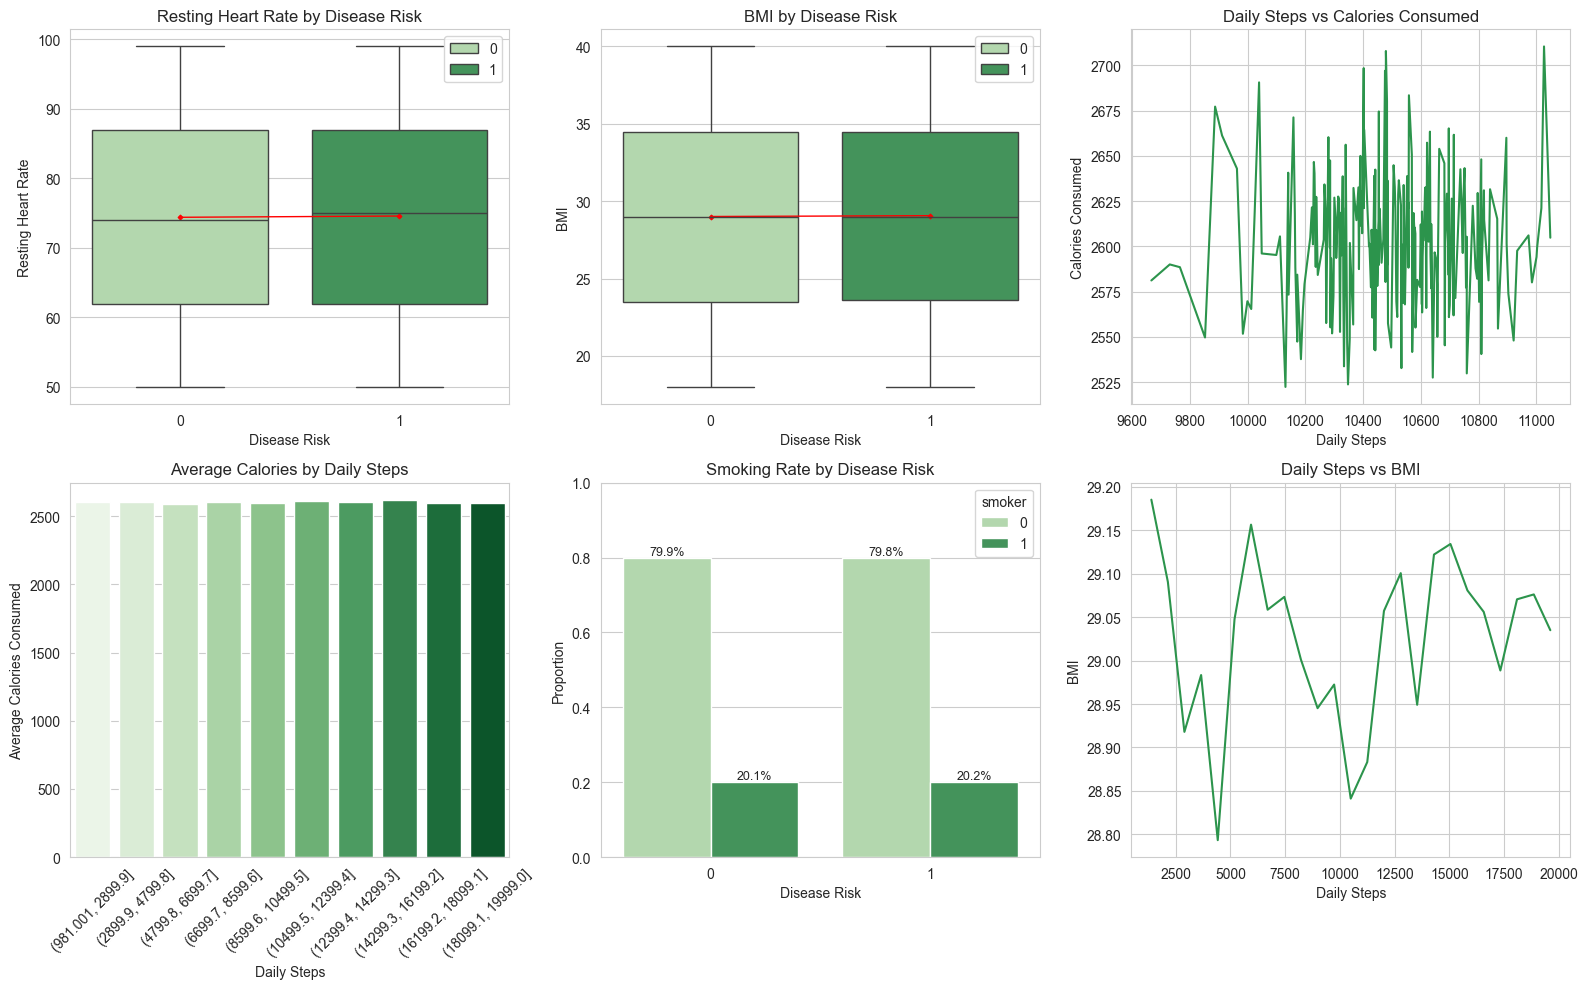

In [34]:

sns.set_style("whitegrid")
plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
sns.boxplot(data=df, x='disease_risk', y='resting_hr', hue='disease_risk', palette='Greens')
plt.title('Resting Heart Rate by Disease Risk')
plt.xlabel('Disease Risk')
plt.ylabel('Resting Heart Rate')
sns.pointplot(
    data=df,
    x='disease_risk',
    y='resting_hr',
    estimator='mean',
    errorbar=None,
    color='red',
    markers='D',
    linestyles='-',
    linewidth=1 
)

plt.subplot(2, 3, 2)
sns.boxplot(data=df, x='disease_risk', y='bmi', hue='disease_risk', palette='Greens')
plt.title('BMI by Disease Risk')
plt.xlabel('Disease Risk')
plt.ylabel('BMI')
sns.pointplot(
    data=df,
    x='disease_risk',
    y='bmi',
    estimator='mean',
    errorbar=None,
    color='red',
    markers='D',
    linestyles='-',
    linewidth=1 
)


plt.subplot(2, 3, 3)
sns.lineplot(
    data=df_mean_1,
    x='daily_steps_mean',
    y='calories_mean',
    color=sns.color_palette("Greens")[4], 
    ci=None
)
plt.title('Daily Steps vs Calories Consumed')
plt.xlabel('Daily Steps')
plt.ylabel('Calories Consumed')

plt.subplot(2, 3, 4)
sns.barplot(
    data=df_bar_1,
    x='step_bin',
    y='calories_mean',
    palette='Greens'
)
plt.title('Average Calories by Daily Steps')
plt.xlabel('Daily Steps')
plt.ylabel('Average Calories Consumed')
plt.xticks(rotation=45)

plt.subplot(2, 3, 5)
ax = sns.barplot(
    data=ratio_df,
    x='disease_risk',
    y='ratio',
    hue='smoker',
    palette='Greens'
)
plt.title('Smoking Rate by Disease Risk')
plt.xlabel('Disease Risk')
plt.ylabel('Proportion')
plt.ylim(0, 1)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f'{height*100:.1f}%',
            (p.get_x() + p.get_width() / 2, height),
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.subplot(2, 3, 6)
sns.lineplot(
    data=df_mean_2,
    x='daily_steps_mean',
    y='bmi_mean',
    color=sns.color_palette("Greens")[4], 
    ci=None
)
plt.title('Daily Steps vs BMI')
plt.xlabel('Daily Steps')
plt.ylabel('BMI')


plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

In [35]:
df.columns

Index(['id', 'age', 'gender', 'bmi', 'daily_steps', 'sleep_hours',
       'water_intake_l', 'calories_consumed', 'smoker', 'alcohol',
       'resting_hr', 'systolic_bp', 'diastolic_bp', 'cholesterol',
       'family_history', 'disease_risk'],
      dtype='object')

### Feature importance

#### Chuẩn bị dữ liệu 

In [36]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split

label_col = "disease_risk"
df_fi = df.copy()

exclude_cols = [label_col]
feature_cols = [c for c in df_fi.columns if c not in exclude_cols]

X_fi = df_fi[feature_cols]
y_fi = df_fi[label_col]
X_fi.drop(columns=['id'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X_fi, y_fi,
    test_size=0.2,
    stratify=y_fi,
    random_state=42
)


C:\Users\NewDat\AppData\Local\Temp\ipykernel_11004\2534891957.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_fi.drop(columns=['id'], inplace=True)


In [37]:
X_train['gender'] = X_train['gender'].astype('category')
X_test['gender']  = X_test['gender'].astype('category')

#### XGBoost

Accuracy: 0.7518
resting_hr           0.075545
bmi                  0.074969
cholesterol          0.074749
systolic_bp          0.074226
water_intake_l       0.074007
calories_consumed    0.073817
sleep_hours          0.073596
daily_steps          0.073127
smoker               0.072190
age                  0.071068
dtype: float32


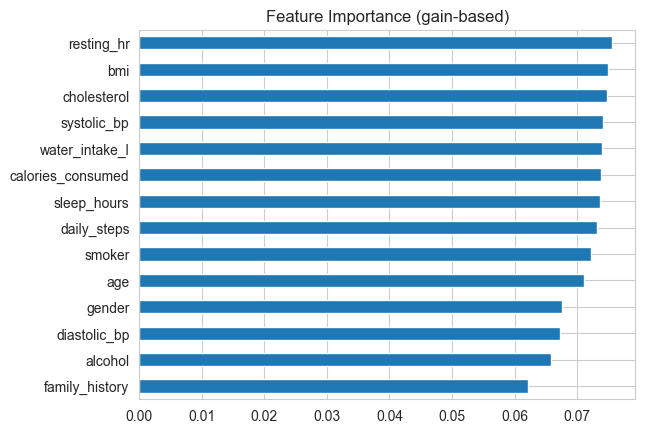

In [38]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    enable_categorical=True
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

importances = model.feature_importances_

feat_imp = pd.Series(importances, index=X_train.columns)
feat_imp = feat_imp.sort_values(ascending=False)

print(feat_imp.head(10))

feat_imp.head(15).plot(kind='barh')
plt.title("Feature Importance (gain-based)")
plt.gca().invert_yaxis()
plt.show()

### Phân tích Chi2

#### Group dữ liệu


Ref: 
https://www.cdc.gov/bmi/adult-calculator/bmi-categories.html



https://www.thensf.org/


https://www.statcan.gc.ca/en/concepts/definitions/age2

In [39]:
df_anova = df.copy()

In [40]:
import pandas as pd

bmi_bins = [0, 18.5, 25, 30, float('inf')]
bmi_labels = [
    'Underweight',
    'Healthy Weight',
    'Overweight',
    'Obesity'
]

df_anova['bmi_group'] = pd.cut(
    df_anova['bmi'],
    bins=bmi_bins,
    labels=bmi_labels,
    right=False  # [18.5, 25)
)

In [41]:
sleep_bins = [0, 6, 7, 9, float('inf')]
sleep_labels = [
    'Very Short Sleep',
    'Short Sleep',
    'Recommended',
    'Long Sleep'
]

df_anova['sleep_group'] = pd.cut(
    df_anova['sleep_hours'],
    bins=sleep_bins,
    labels=sleep_labels,
    right=False
)

In [42]:
age_bins = [15, 25, 65, float('inf')]
age_labels = [
    'Youth',
    'Adults',
    'Seniors'
]

df_anova['age_group'] = pd.cut(
    df_anova['age'],
    bins=age_bins,
    labels=age_labels,
    right=False
)

In [43]:
anova_columns = ['age_group', 'bmi_group', 'sleep_group', 'gender', 'smoker', 'alcohol', 'disease_risk']

In [44]:
df_anova[anova_columns]

,age_group,bmi_group,sleep_group,gender,smoker,alcohol,disease_risk
0,Adults,Healthy Weight,Very Short Sleep,Male,0,0,0
1,Seniors,Obesity,Long Sleep,Female,0,1,0
2,Adults,Obesity,Short Sleep,Male,0,1,0
3,Adults,Obesity,Very Short Sleep,Female,0,0,0
4,Adults,Obesity,Very Short Sleep,Female,0,1,0
...,...,...,...,...,...,...,...
99995,Adults,Obesity,Very Short Sleep,Male,0,1,0
99996,Youth,Obesity,Very Short Sleep,Male,0,0,0
99997,Adults,Healthy Weight,Very Short Sleep,Male,0,0,0
99998,Seniors,Overweight,Very Short Sleep,Female,0,0,0


#### Chi2 result

In [45]:
import pandas as pd
from scipy.stats import chi2_contingency

results = []

target = 'disease_risk'

for col in anova_columns:
    ct = pd.crosstab(df_anova[col], df_anova[target])

    chi2, p, dof, expected = chi2_contingency(ct)

    results.append({
        'variable': col,
        'chi2': chi2,
        'dof': dof,
        'p_value': p
    })

df_chi2 = pd.DataFrame(results).sort_values('p_value')
df_chi2

,variable,chi2,dof,p_value
6,disease_risk,99994.641067,1,0.000000
1,bmi_group,6.495960,3,0.089822
2,sleep_group,3.452037,3,0.327036
3,gender,0.373891,1,0.540891
4,smoker,0.120086,1,0.728941
0,age_group,0.474090,2,0.788956
5,alcohol,0.024028,1,0.876814


### Check label imbalance

In [46]:
df["disease_risk"].value_counts()

disease_risk
0    75179
1    24821
Name: count, dtype: int64

## **Conclusion**
Cơ bản bộ dữ liệu đã được có định dạng đẹp 

## Machine learning Analysis

In [47]:
df.head()

,id,age,gender,bmi,daily_steps,sleep_hours,water_intake_l,calories_consumed,smoker,alcohol,resting_hr,systolic_bp,diastolic_bp,cholesterol,family_history,disease_risk
0,1,56,Male,20.5,4198,3.9,3.4,1602,0,0,97,161,111,240,0,0
1,2,69,Female,33.3,14359,9.0,4.7,2346,0,1,68,116,65,207,0,0
2,3,46,Male,31.6,1817,6.6,4.2,1643,0,1,90,123,99,296,0,0
3,4,32,Female,38.2,15772,3.6,2.0,2460,0,0,71,165,95,175,0,0
4,5,60,Female,33.6,6037,3.8,4.0,3756,0,1,98,139,61,294,0,0


### Mapping Categorical columns

In [48]:
gender = {
    "Male": 0, 
    "Female": 1
}


df['gender'] = df['gender'].map(gender)

In [49]:
df

,id,age,gender,bmi,daily_steps,sleep_hours,water_intake_l,calories_consumed,smoker,alcohol,resting_hr,systolic_bp,diastolic_bp,cholesterol,family_history,disease_risk
0,1,56,0,20.5,4198,3.9,3.4,1602,0,0,97,161,111,240,0,0
1,2,69,1,33.3,14359,9.0,4.7,2346,0,1,68,116,65,207,0,0
2,3,46,0,31.6,1817,6.6,4.2,1643,0,1,90,123,99,296,0,0
3,4,32,1,38.2,15772,3.6,2.0,2460,0,0,71,165,95,175,0,0
4,5,60,1,33.6,6037,3.8,4.0,3756,0,1,98,139,61,294,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,53,0,33.1,4726,3.9,2.0,3118,0,1,56,105,76,282,0,0
99996,99997,22,0,35.1,11554,4.5,3.1,1967,0,0,51,149,77,192,0,0
99997,99998,37,0,18.9,3924,3.8,1.0,2328,0,0,69,92,117,218,0,0
99998,99999,72,1,27.8,16110,5.6,0.8,3093,0,0,93,164,72,188,0,0


### Correlation - Multicollinear Checking

In [50]:
corr_numeric, corr_ordinal, corr_categorical, corr_target_numeric, corr_target_categorical = calc_correlation(df, continuous_columns, categorical_columns, target='disease_risk')

No ordinal columns provided.


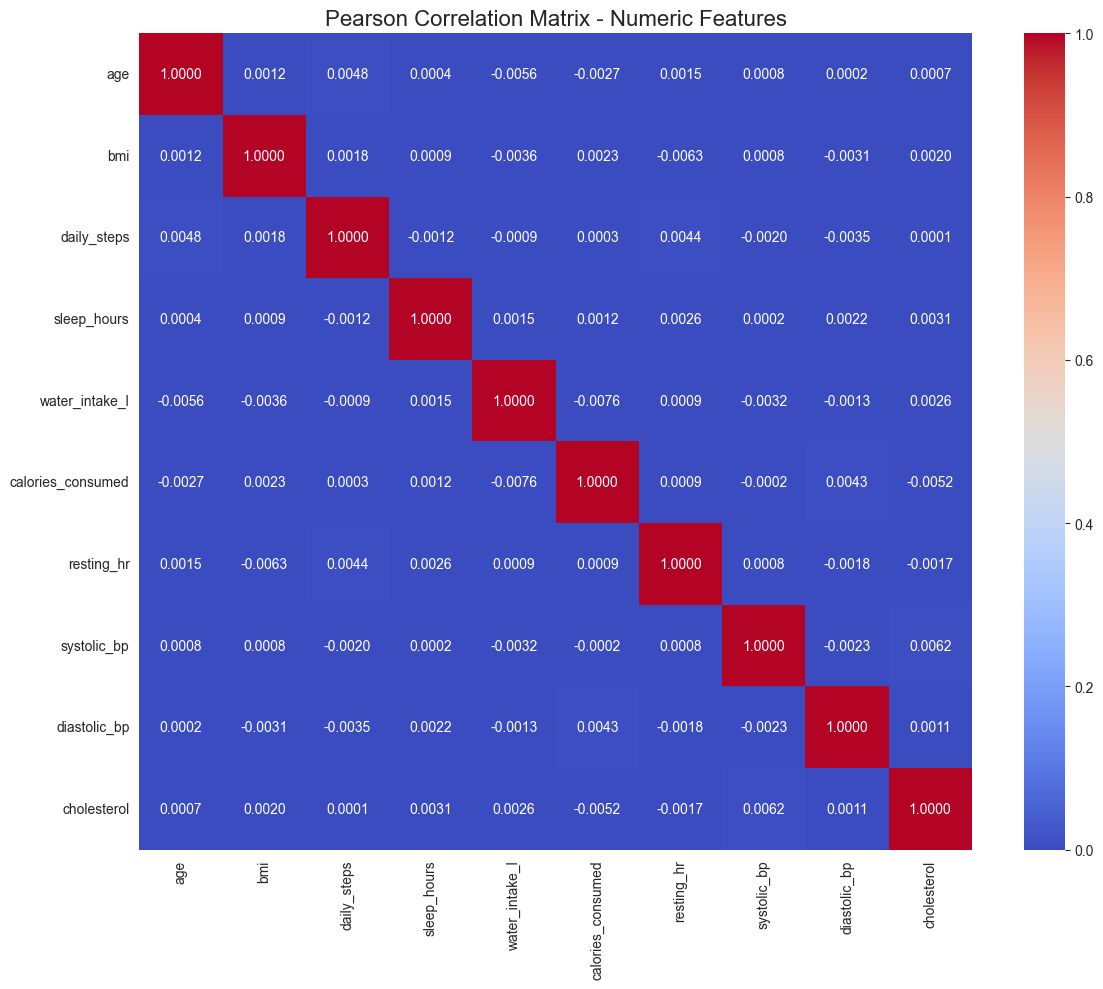

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

show_heat_map(corr_numeric, title='Pearson Correlation Matrix - Numeric Features')

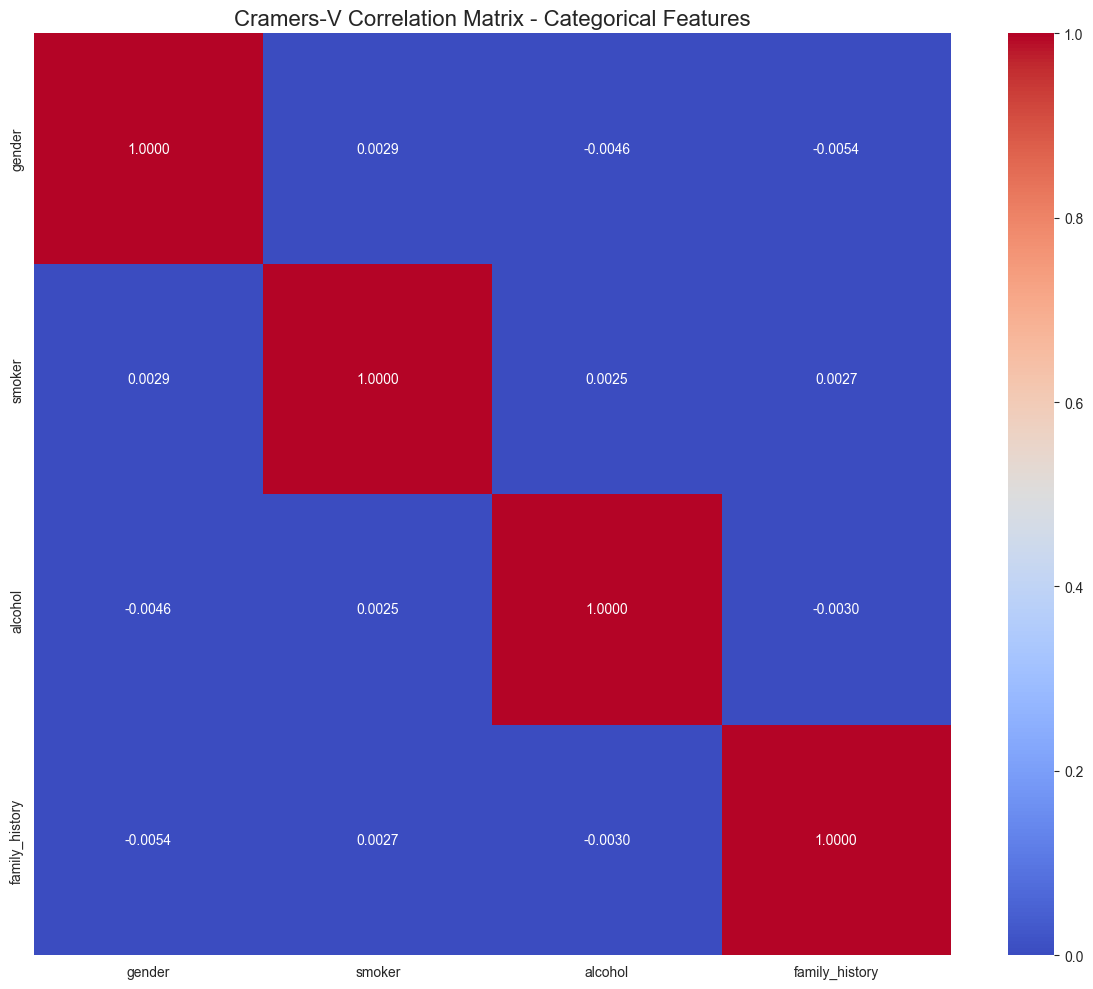

In [52]:
show_heat_map(corr_categorical, "Cramers-V Correlation Matrix - Categorical Features")

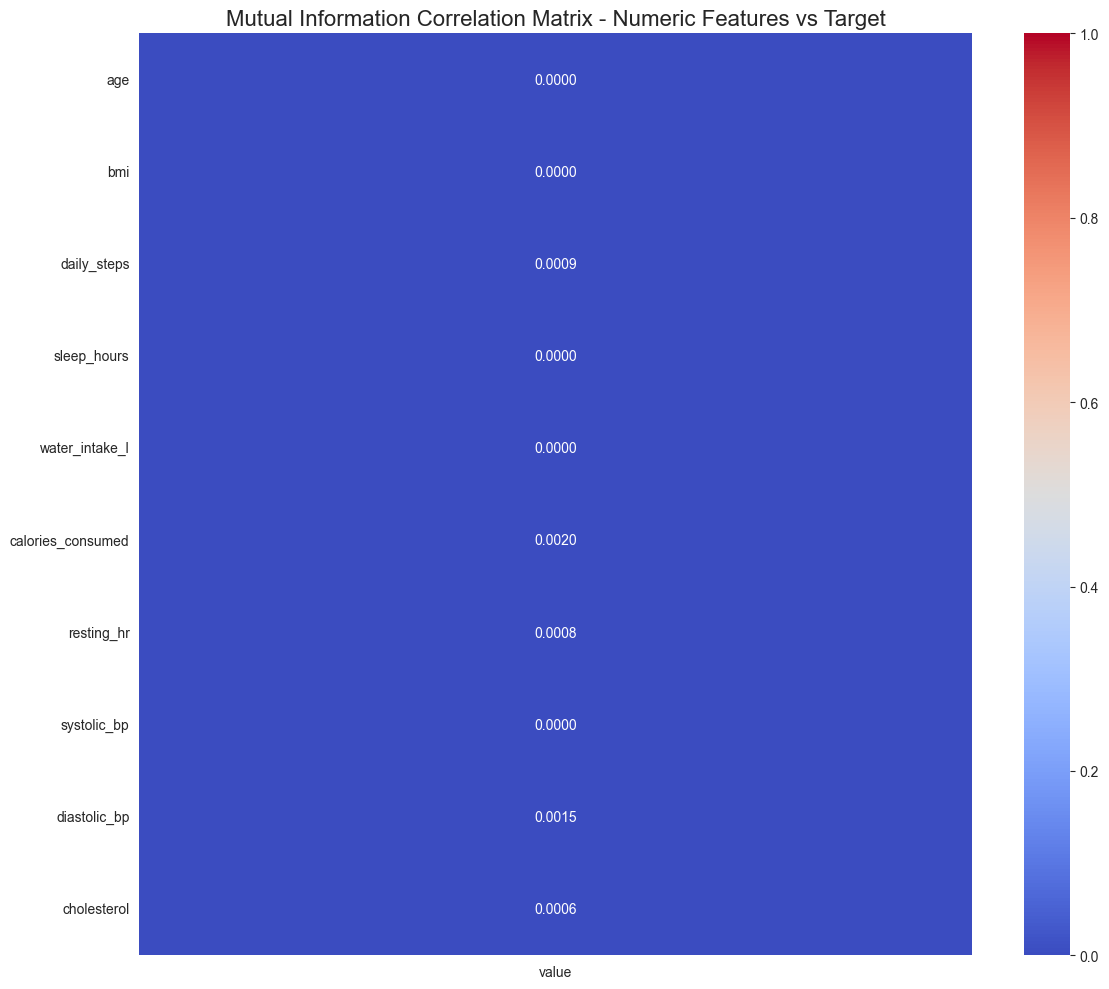

In [53]:
show_heat_map(corr_target_numeric, "Mutual Information Correlation Matrix - Numeric Features vs Target")

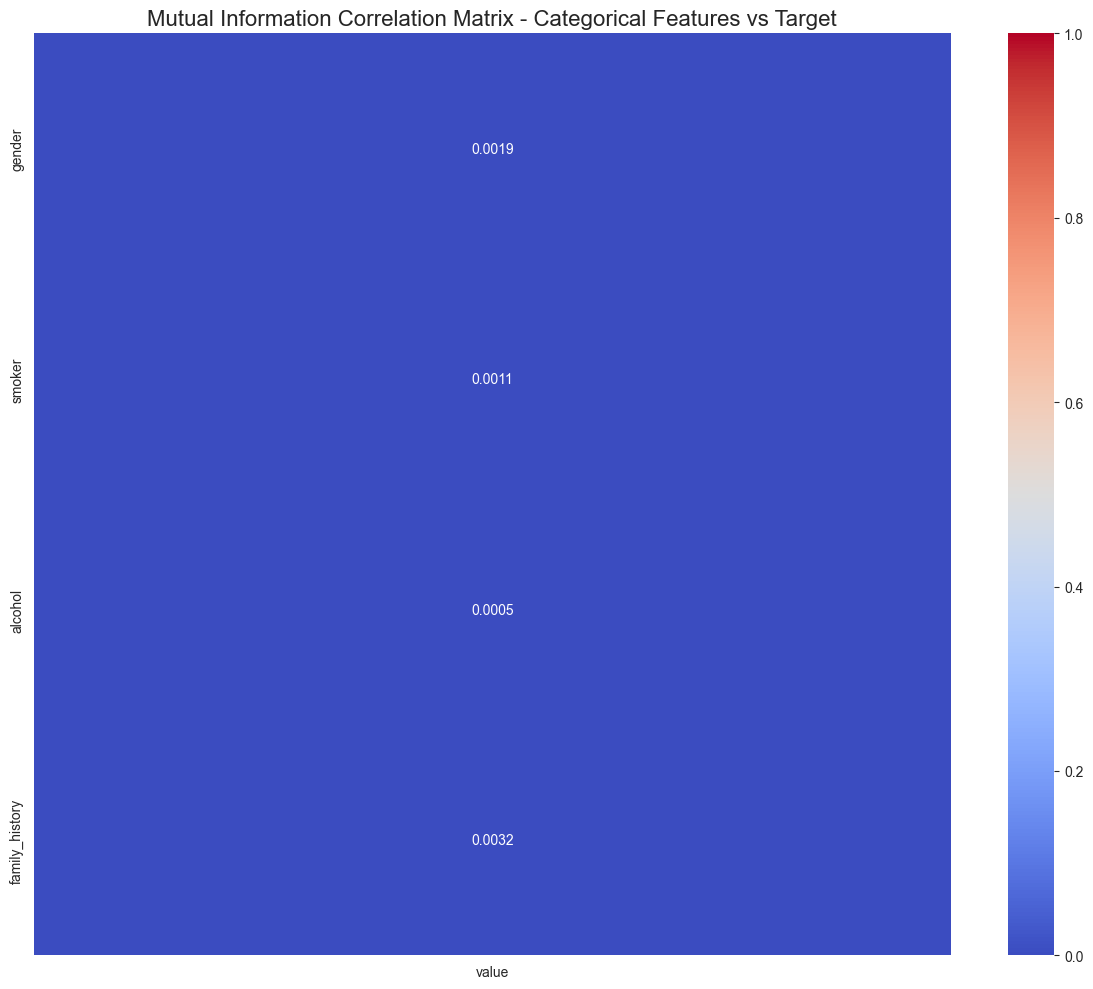

In [54]:
show_heat_map(corr_target_categorical, "Mutual Information Correlation Matrix - Categorical Features vs Target")

### Z-score

In [55]:
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
df_scaled = df.copy()
continuous_columns_features = continuous_columns.copy()

df_scaled[continuous_columns_features] = scaler.fit_transform(df[continuous_columns_features])


In [56]:
df_scaled.drop("id", axis=1, inplace=True)

In [57]:
categorical_columns

['gender', 'smoker', 'alcohol', 'family_history']

Text(0.5, 1.0, 'After Scaling')

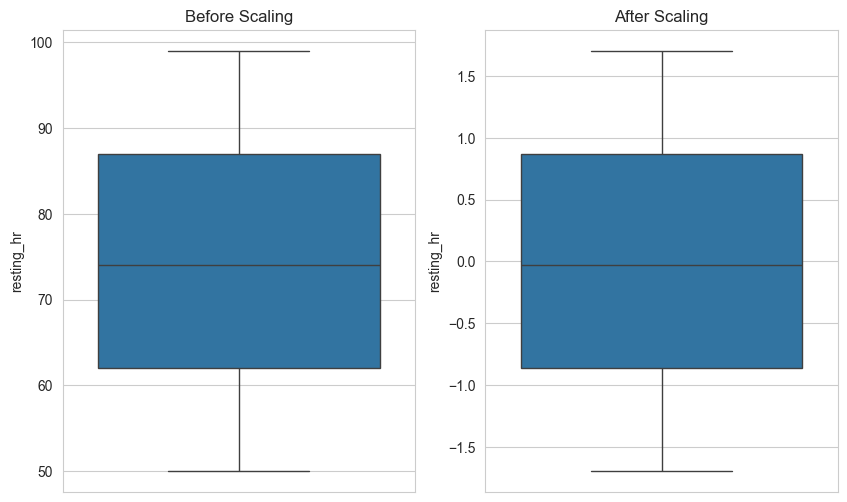

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

sns.boxplot(y=df['resting_hr'], ax=axes[0])
axes[0].set_title('Before Scaling')

sns.boxplot(y=df_scaled['resting_hr'], ax=axes[1])
axes[1].set_title('After Scaling')

In [59]:
df_scaled

,age,gender,bmi,daily_steps,sleep_hours,water_intake_l,calories_consumed,smoker,alcohol,resting_hr,systolic_bp,diastolic_bp,cholesterol,family_history,disease_risk
0,0.417853,0,-1.341930,-1.145573,-1.281848,0.499875,-1.240382,0,0,1.562891,1.018033,1.238900,0.362342,0,0
1,1.144651,1,0.672982,0.707405,1.240517,1.501933,-0.318774,0,1,-0.447697,-0.715978,-1.412862,-0.399299,0,0
2,-0.141222,0,0.405377,-1.579777,0.053522,1.116526,-1.189594,0,1,1.077577,-0.446243,0.547136,1.654822,0,0
3,-0.923927,1,1.444316,0.965082,-1.430222,-0.579263,-0.177560,0,0,-0.239705,1.172167,0.316548,-1.137859,0,0
4,0.641484,1,0.720207,-0.810210,-1.331306,0.962363,1.427822,0,1,1.632221,0.170294,-1.643450,1.608662,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.250131,0,0.641499,-1.049286,-1.281848,-0.579263,0.637518,0,1,-1.279664,-1.139847,-0.778745,1.331702,0,0
99996,-1.483003,0,0.956329,0.195880,-0.985099,0.268631,-0.788249,0,0,-1.626317,0.555630,-0.721098,-0.745499,0,0
99997,-0.644390,0,-1.593794,-1.195540,-1.331306,-1.350076,-0.341071,0,0,-0.378366,-1.640783,1.584783,-0.145419,0,0
99998,1.312374,1,-0.192800,1.026721,-0.441060,-1.504239,0.606550,0,0,1.285568,1.133633,-1.009333,-0.837819,0,0


### Check data imbalance

In [60]:
df_scaled['disease_risk'].value_counts()[1]/df_scaled['disease_risk'].value_counts()[0] *100

np.float64(33.01586879314702)

In [61]:
df_scaled

,age,gender,bmi,daily_steps,sleep_hours,water_intake_l,calories_consumed,smoker,alcohol,resting_hr,systolic_bp,diastolic_bp,cholesterol,family_history,disease_risk
0,0.417853,0,-1.341930,-1.145573,-1.281848,0.499875,-1.240382,0,0,1.562891,1.018033,1.238900,0.362342,0,0
1,1.144651,1,0.672982,0.707405,1.240517,1.501933,-0.318774,0,1,-0.447697,-0.715978,-1.412862,-0.399299,0,0
2,-0.141222,0,0.405377,-1.579777,0.053522,1.116526,-1.189594,0,1,1.077577,-0.446243,0.547136,1.654822,0,0
3,-0.923927,1,1.444316,0.965082,-1.430222,-0.579263,-0.177560,0,0,-0.239705,1.172167,0.316548,-1.137859,0,0
4,0.641484,1,0.720207,-0.810210,-1.331306,0.962363,1.427822,0,1,1.632221,0.170294,-1.643450,1.608662,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.250131,0,0.641499,-1.049286,-1.281848,-0.579263,0.637518,0,1,-1.279664,-1.139847,-0.778745,1.331702,0,0
99996,-1.483003,0,0.956329,0.195880,-0.985099,0.268631,-0.788249,0,0,-1.626317,0.555630,-0.721098,-0.745499,0,0
99997,-0.644390,0,-1.593794,-1.195540,-1.331306,-1.350076,-0.341071,0,0,-0.378366,-1.640783,1.584783,-0.145419,0,0
99998,1.312374,1,-0.192800,1.026721,-0.441060,-1.504239,0.606550,0,0,1.285568,1.133633,-1.009333,-0.837819,0,0


### Train - test split

In [62]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

label_col = "disease_risk"

exclude_cols = [label_col]
feature_cols = [c for c in df_scaled.columns if c not in exclude_cols]

X = df_scaled[feature_cols]
y = df_scaled[label_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_sm.value_counts())
X_train = X_train_sm
y_train = y_train_sm


Before SMOTE: disease_risk
0    60143
1    19857
Name: count, dtype: int64
After SMOTE: disease_risk
0    60143
1    60143
Name: count, dtype: int64


In [63]:
X_train_LR = pd.get_dummies(X_train, columns=categorical_columns)
X_test_LR  = pd.get_dummies(X_test, columns=categorical_columns)

In [64]:
X_train_LR

,age,bmi,daily_steps,sleep_hours,water_intake_l,calories_consumed,resting_hr,systolic_bp,diastolic_bp,cholesterol,gender_0,gender_1,smoker_0,smoker_1,alcohol_0,alcohol_1,family_history_0,family_history_1
0,1.480096,1.633214,-1.207394,-1.281848,1.193607,-0.796920,-0.447697,0.247361,-1.701097,1.677902,False,True,True,False,False,True,True,False
1,-1.259372,1.239676,-1.296022,-1.726971,-0.425100,-0.939373,-1.071672,-0.330642,-0.490510,0.293102,False,True,False,True,True,False,False,True
2,-1.147557,-0.129834,0.201169,-1.380764,-0.193856,0.097436,-0.031713,1.210700,-0.605804,-1.068619,False,True,False,True,False,True,True,False
3,-0.868020,-0.964134,0.690992,1.191059,1.579014,-0.725074,-1.626317,0.054693,0.777724,0.200782,True,False,True,False,True,False,True,False
4,-0.532575,0.987812,0.999731,1.685640,-0.579263,1.269266,-1.348995,0.170294,-1.528156,0.362342,False,True,False,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120281,-1.560914,0.538515,0.817834,-1.458627,-1.242657,0.809305,0.569221,0.614049,0.662430,-0.704183,True,False,True,False,True,False,True,False
120282,0.028785,0.925490,-0.408902,-1.025258,-1.708179,-0.104667,0.641379,0.769192,0.584363,-0.993090,False,True,True,False,True,False,True,False
120283,-1.258796,-0.420060,-0.922285,1.449920,1.472408,0.330673,-0.388703,-1.059510,0.862937,1.654822,False,True,True,False,False,True,True,False
120284,-0.631513,-0.060524,1.296445,-0.622184,1.173635,0.672647,1.277584,-1.381033,0.015036,0.321144,True,False,True,False,False,True,True,False


# Machine Learning 

In [65]:
label_col = "label"
exclude_cols = ["user_id", "course_id", label_col]

feature_cols = [c for c in X_train_LR.columns if c not in exclude_cols]

X_train = X_train_LR[feature_cols]
y_train = y_train

X_test = X_test_LR[feature_cols]
y_test = y_test

In [66]:
X_train

,age,bmi,daily_steps,sleep_hours,water_intake_l,calories_consumed,resting_hr,systolic_bp,diastolic_bp,cholesterol,gender_0,gender_1,smoker_0,smoker_1,alcohol_0,alcohol_1,family_history_0,family_history_1
0,1.480096,1.633214,-1.207394,-1.281848,1.193607,-0.796920,-0.447697,0.247361,-1.701097,1.677902,False,True,True,False,False,True,True,False
1,-1.259372,1.239676,-1.296022,-1.726971,-0.425100,-0.939373,-1.071672,-0.330642,-0.490510,0.293102,False,True,False,True,True,False,False,True
2,-1.147557,-0.129834,0.201169,-1.380764,-0.193856,0.097436,-0.031713,1.210700,-0.605804,-1.068619,False,True,False,True,False,True,True,False
3,-0.868020,-0.964134,0.690992,1.191059,1.579014,-0.725074,-1.626317,0.054693,0.777724,0.200782,True,False,True,False,True,False,True,False
4,-0.532575,0.987812,0.999731,1.685640,-0.579263,1.269266,-1.348995,0.170294,-1.528156,0.362342,False,True,False,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120281,-1.560914,0.538515,0.817834,-1.458627,-1.242657,0.809305,0.569221,0.614049,0.662430,-0.704183,True,False,True,False,True,False,True,False
120282,0.028785,0.925490,-0.408902,-1.025258,-1.708179,-0.104667,0.641379,0.769192,0.584363,-0.993090,False,True,True,False,True,False,True,False
120283,-1.258796,-0.420060,-0.922285,1.449920,1.472408,0.330673,-0.388703,-1.059510,0.862937,1.654822,False,True,True,False,False,True,True,False
120284,-0.631513,-0.060524,1.296445,-0.622184,1.173635,0.672647,1.277584,-1.381033,0.015036,0.321144,True,False,True,False,False,True,True,False


#### Dataset masking, mimic dropout

In [67]:
import numpy as np

def feature_dropout(X, p=0.1):
    mask = np.random.binomial(1, 1-p, X.shape)
    return X * mask

X_train_aug = feature_dropout(X_train.values, p=0.2)

In [68]:
X_train_aug

array([[1.4800964938322396, 1.6332138253719473, -0.0, ..., 1, 1, 0],
       [-1.259372449398489, 1.2396762908613332, -1.2960215707218752, ...,
        0, 0, 1],
       [-1.1475573904911123, -0.12983432923560317, 0.0, ..., 1, 0, 0],
       ...,
       [-1.2587963241831435, -0.4200598404933078, -0.9222850085836771,
        ..., 1, 1, 0],
       [-0.6315130186716824, -0.060523561779062235, 1.2964453417188688,
        ..., 1, 1, 0],
       [0.8799723897864957, 0.1682610250429494, -0.0, ..., 0, 0, 0]],
      shape=(120286, 18), dtype=object)

#### Full train dataset


================ Logistic Regression ================
Accuracy : 0.4957
Precision: 0.4986
Recall   : 0.4982
F1-score : 0.4632


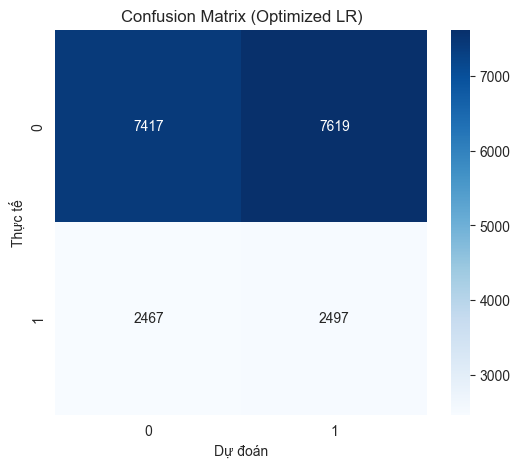


================ Decision Tree ================
Accuracy : 0.5180
Precision: 0.4968
Recall   : 0.4958
F1-score : 0.4725


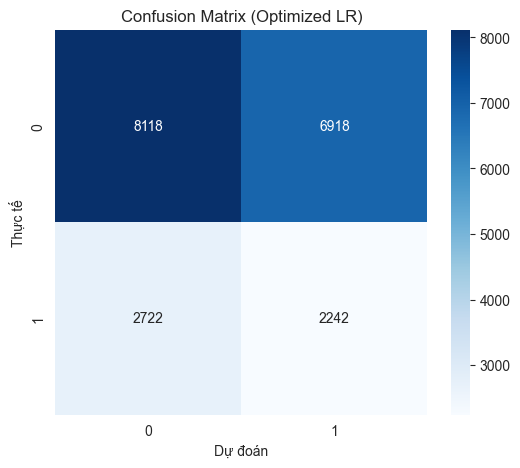


================ Random Forest ================
Accuracy : 0.6911
Precision: 0.4916
Recall   : 0.4955
F1-score : 0.4791


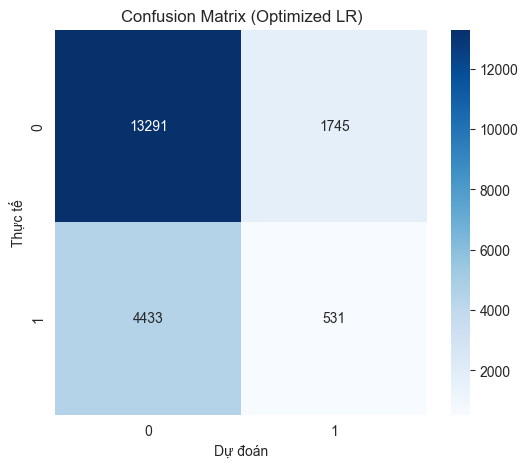


================ XGBoost ================


c:\Users\NewDat\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:15:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy : 0.7290
Precision: 0.4885
Recall   : 0.4976
F1-score : 0.4532


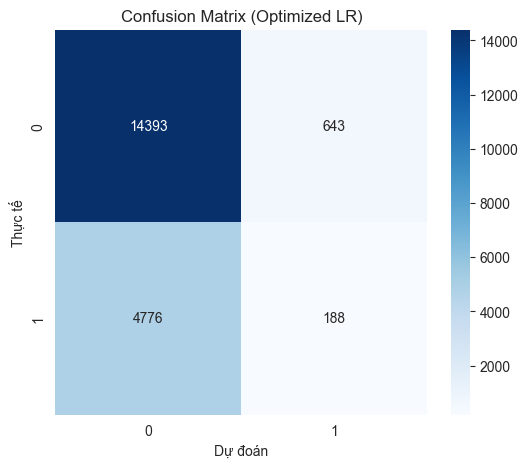

In [69]:
import matplotlib.pyplot as plt

results = []
for model_name, model in model_dict.items():
    print(f"\n================ {model_name} ================")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    
    # Vẽ ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Optimized LR)')
    plt.ylabel('Thực tế')
    plt.xlabel('Dự đoán')
    plt.show()

    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })


#### Train khi có dropout để model robust hơn


================ Logistic Regression ================
Accuracy : 0.4933
Precision: 0.4985
Recall   : 0.4980
F1-score : 0.4619


c:\Users\NewDat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


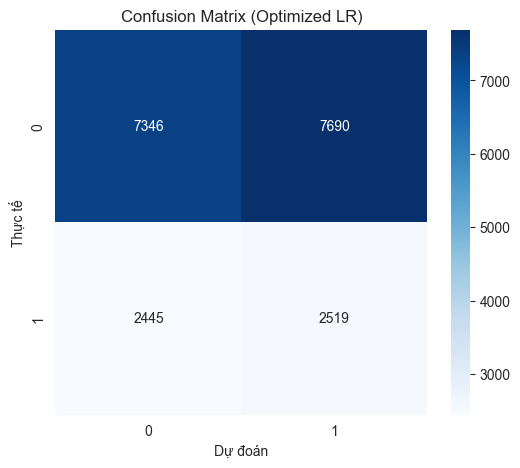


================ Decision Tree ================
Accuracy : 0.5197
Precision: 0.4983
Recall   : 0.4978
F1-score : 0.4742


c:\Users\NewDat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


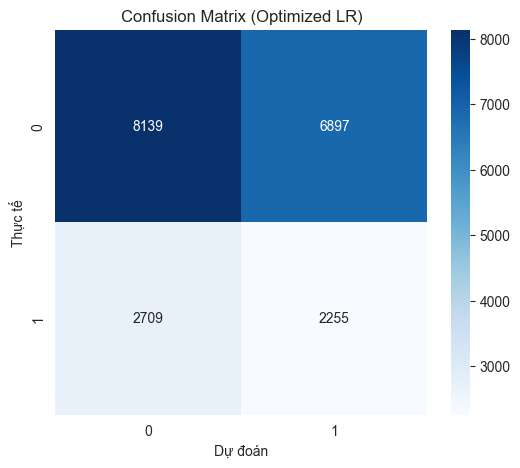


================ Random Forest ================


c:\Users\NewDat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy : 0.6542
Precision: 0.4884
Recall   : 0.4908
F1-score : 0.4864


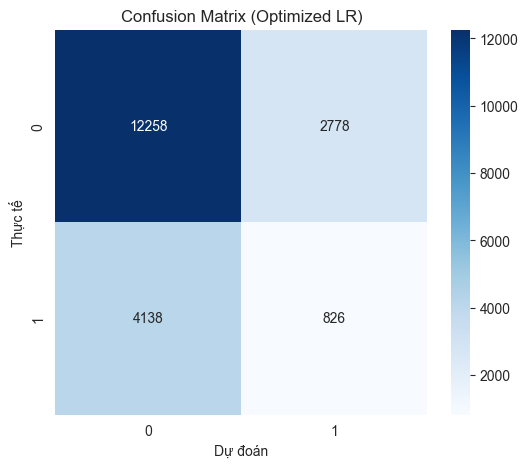


================ XGBoost ================


c:\Users\NewDat\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:22:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy : 0.7260
Precision: 0.4956
Recall   : 0.4989
F1-score : 0.4595


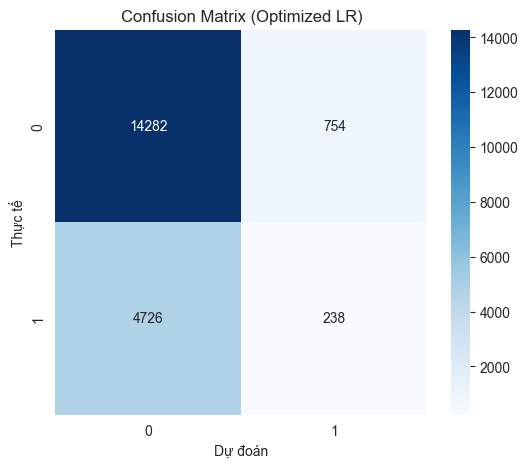

In [70]:
import matplotlib.pyplot as plt

results = []
for model_name, model in model_dict.items():
    print(f"\n================ {model_name} ================")

    model.fit(X_train_aug, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    
    # Vẽ ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Optimized LR)')
    plt.ylabel('Thực tế')
    plt.xlabel('Dự đoán')
    plt.show()

    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })


In [71]:
results

[{'Model': 'Logistic Regression',
  'Accuracy': 0.49325,
  'Precision': 0.4985119700136217,
  'Recall': 0.49800722692076754,
  'F1': 0.46190612743473575},
 {'Model': 'Decision Tree',
  'Accuracy': 0.5197,
  'Precision': 0.4983353897208985,
  'Recall': 0.4977858136443527,
  'F1': 0.4741891576424915},
 {'Model': 'Random Forest',
  'Accuracy': 0.6542,
  'Precision': 0.48840558009465507,
  'Recall': 0.4908207409389102,
  'F1': 0.4863899576968312},
 {'Model': 'XGBoost',
  'Accuracy': 0.726,
  'Precision': 0.49564359997827745,
  'Recall': 0.498899444985004,
  'F1': 0.4594756250730398}]